In [1]:
import os
from typing import TypedDict, Annotated, List
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq

# Load environment variables
load_dotenv()


# Define the state
class AssistantState(MessagesState):
    task_decision: str
    database_agent_response: str
    invalid_decision_count: int


def query_crewai_backend(query: str) -> str:
    return f"CrewAI Agent response: Based on the query '{query}', here's the information..."


def get_chat_model() -> BaseChatModel:
    return ChatGroq(temperature=0)


# Node functions
def main_conversation(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "You are a helpful assistant for a student. Respond based on the conversation and any information from the CrewAI agents."),
        ("human", "{input}"),
        ("ai", "CrewAI Agent info: {database_agent_response}\nResponse:"),
    ])
    chain = prompt | chat
    response = chain.invoke({
        "input": state["messages"][-1].content,
        "database_agent_response": state.get("database_agent_response", "No additional information available.")
    })
    return {"messages": [AIMessage(content=response.content)]}


def task_planning(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "Decide if we need to consult the CrewAI agents for more information or if we can respond directly. Output ONLY 'query' or 'respond'."),
        ("human", "{input}"),
        ("system", "Invalid decisions so far: {invalid_count}"),
    ])
    chain = prompt | chat
    decision = chain.invoke({
        "input": state["messages"][-1].content,
        "invalid_count": state.get("invalid_decision_count", 0)
    })
    decision_content = decision.content.strip().lower()

    if decision_content not in ["query", "respond"]:
        return {
            "task_decision": "invalid",
            "invalid_decision_count": state.get("invalid_decision_count", 0) + 1
        }

    return {
        "task_decision": decision_content,
        "invalid_decision_count": 0  # Reset the counter when a valid decision is made
    }


def crewai_agent_query(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Formulate a natural language query for the CrewAI agents based on the student's question."),
        ("human", "{input}"),
    ])
    chain = prompt | chat
    result = chain.invoke({"input": state["messages"][-1].content})
    return {"database_agent_response": result['agent_response']}


# Create the graph
workflow = StateGraph(AssistantState)

# Add nodes
workflow.add_node("main_conversation", main_conversation)
workflow.add_node("task_planning", task_planning)
workflow.add_node("crewai_agent_query", crewai_agent_query)

# Add edges
workflow.set_entry_point("task_planning")
workflow.add_conditional_edges(
    "task_planning",
    lambda x: "crewai_agent_query" if x["task_decision"] == "query" else (
        "main_conversation" if x["task_decision"] == "respond" else "task_planning"),
    {
        "crewai_agent_query": "crewai_agent_query",
        "main_conversation": "main_conversation",
        "task_planning": "task_planning"
    }
)
workflow.add_edge("main_conversation", END)

# Compile the graph
app = workflow.compile()    

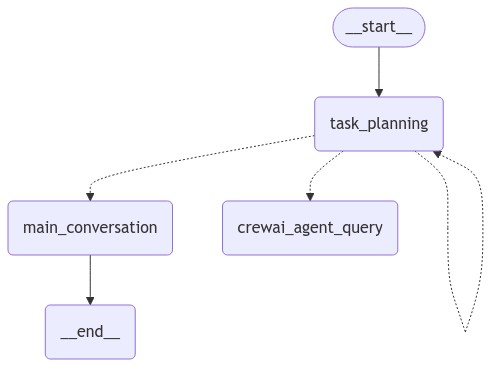

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.API,
            background_color="white",
            padding=10,
        )
    )
)

In [3]:
# messages = []
# while True:
#     messages.append(HumanMessage(content=input("You:")))
#     result = app.invoke({"messages": messages})
#     print("\n\nFinal result:")
#     print(result['messages'][-1].content)